In [9]:
import sys

# Check if running on Google Colab
# If so, mount Google Drive and download CIFAR-10 dataset
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    # assignment folder, e.g. 'cs231n/assignments/assignment1/'
    FOLDERNAME = 'cs231n/assignments/assignment1/'
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

    # This downloads the CIFAR-10 dataset to your Drive
    # if it doesn't already exist.
    %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
    !bash get_datasets.sh
    %cd /content/drive/My\ Drive/$FOLDERNAME
# END OF COLAB SETUP

# If not running on Google Colab, download CIFAR-10 dataset locally
else:
    print("Not running on Google Colab")
    %cd ./cs231n/datasets/
    !bash get_datasets.sh
    %cd ../..

Running on Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://eva.fing.edu.uy/mod/assign/view.php?id=194303) on the course website.*

You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [10]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [12]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.334947
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$

Tenemos que nuestra función de costo se calcula de la siguiente manera:

$ L_{i} = -log\left( \frac{e^{f_{y_i}}}{\sum e^{f_j}} \right) $

Dicha función puede ser interpretada como la probabilidad de la etiqueta correcta $y_i$ dada la imagen $x_i$ y parametrizada por $W$.

$ P( y_{i} | x_{1}; W) = \frac {e^{f_{y_i}}}{\sum e^{f_j}} $

Dado que en nuestro problema de clasificación contamos con 10 clases:

$ P( y_{i} | x_{1}; W) = 1/10 $ para un $W$ aleatorio.  

y por lo tanto: $ L_{i} ≈ -log(0.1) $

In [13]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.359451 analytic: 0.359451, relative error: 9.661701e-08
numerical: -4.538208 analytic: -4.538208, relative error: 8.642161e-09
numerical: 1.856921 analytic: 1.856921, relative error: 9.941005e-09
numerical: 3.216175 analytic: 3.216175, relative error: 5.532237e-09
numerical: 3.131191 analytic: 3.131191, relative error: 2.798351e-09
numerical: 0.214559 analytic: 0.214559, relative error: 8.510426e-08
numerical: 0.578757 analytic: 0.578757, relative error: 3.311313e-08
numerical: 0.044976 analytic: 0.044976, relative error: 1.543957e-06
numerical: -0.769072 analytic: -0.769072, relative error: 9.891776e-09
numerical: 3.801710 analytic: 3.801710, relative error: 5.652629e-09
numerical: 0.721764 analytic: 0.721764, relative error: 3.185568e-09
numerical: 4.167513 analytic: 4.167513, relative error: 6.210757e-09
numerical: -1.395116 analytic: -1.395116, relative error: 2.648160e-08
numerical: -1.372636 analytic: -1.372636, relative error: 5.414163e-08
numerical: 0.219428 analyt

In [14]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.334947e+00 computed in 0.091656s
vectorized loss: 2.334947e+00 computed in 0.010959s
Loss difference: 0.000000
Gradient difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [15]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 393.561479
iteration 100 / 1500: loss 238.354209
iteration 200 / 1500: loss 144.725079
iteration 300 / 1500: loss 88.270037
iteration 400 / 1500: loss 54.217817
iteration 500 / 1500: loss 33.566775
iteration 600 / 1500: loss 21.116086
iteration 700 / 1500: loss 13.529906
iteration 800 / 1500: loss 9.011594
iteration 900 / 1500: loss 6.196970
iteration 1000 / 1500: loss 4.579791
iteration 1100 / 1500: loss 3.564438
iteration 1200 / 1500: loss 3.008224
iteration 1300 / 1500: loss 2.653072
iteration 1400 / 1500: loss 2.355481
That took 6.651754s


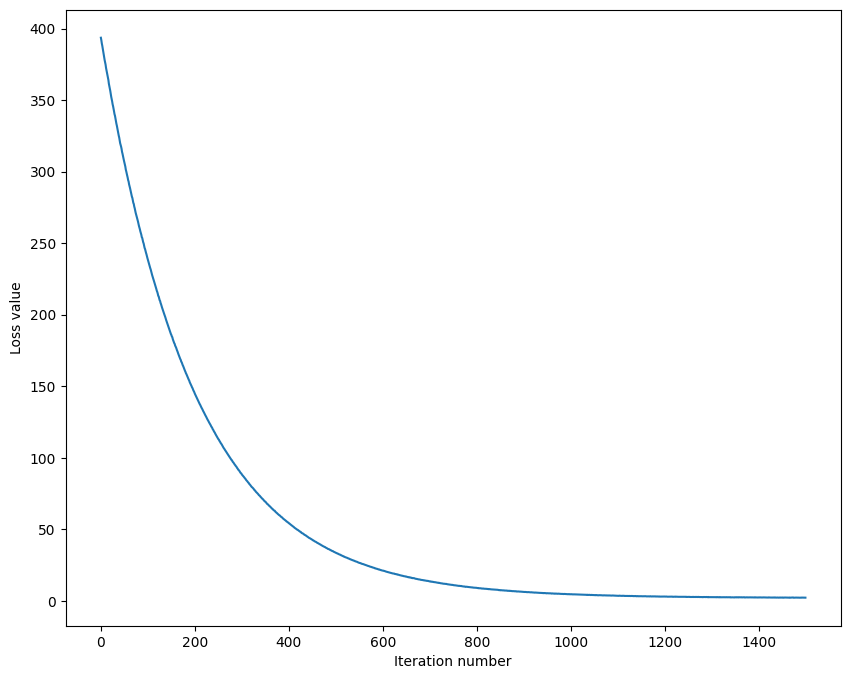

In [16]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [17]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.349367
validation accuracy: 0.366000


In [24]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in best_softmax.                     #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.351653 val accuracy: 0.364000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.330286 val accuracy: 0.345000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.339184 val accuracy: 0.358000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.326408 val accuracy: 0.346000
best validation accuracy achieved during cross-validation: 0.364000


In [25]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.356000


**Inline Question 2** - *Softmax loss with Temperature*

Suppose we want to use a temperature parameter $T$ for the softmax distribution:
$$P(i) = \frac{e^{\frac{f_i}{T}}}{\sum_j e^{\frac{f_j}{T}}} $$
where $f_i$ is the score for class $i$
- What values of $T$ would make the model more confident about its predictions?


$\color{blue}{\textit Your Answer:}$

El parámetro de temperatura regula la "suavidad" de la distribución de probabilidades.

- Cuando T → ∞, la distribución de probabilidad se convierte en una distribución uniforme. Esto hace que las predicciones para cada clase se vuelvan más similares, lo que significa que el modelo no puede distinguir la clase correcta de manera efectiva, agregando insertidumbre a la predicción.
-  Cuando T → 0,  la distribución de probabilidad se concentra en un punto.
Esto hace que algunas clases tengan probabilidades mucho más altas que las demás, indicando que el modelo tiene una mayor confianza en sus predicciones.

En consecuencia, aumentar $T$ en la función softmax disminuirá la confianza del modelo en sus predicciones, mientras que disminuir $T$ aumentará esa confianza.

Entonces, el intervalo de valores de T que hace que el modelo sea más confiable es: `(0, 1]`

![image.png](https://miro.medium.com/v2/resize:fit:720/format:webp/0*7xj72SjtNHvCMQlV.jpeg)

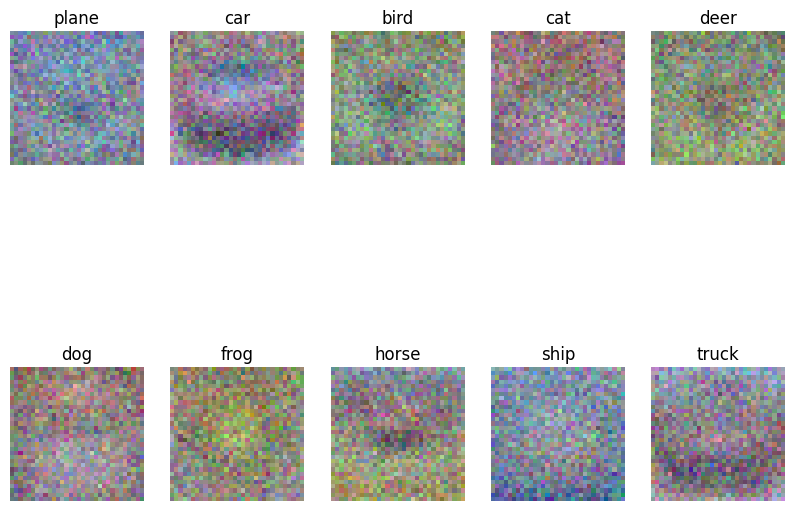

In [22]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])